## Experimental ground: random collection of approaches and testing of different functions

In [1]:
# libraries 
import numpy as np
import tensorflow as tf
import time
import h5py
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.animation as animation
from IPython.display import display
import sys
# sys.path.insert(0, 'C:/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/src')
sys.path.insert(0, '../../src')

# from Network.PatchHandler3D import PatchHandler3D
# functions
from testing.test_iterator import check_compatibility, load_indexes
from Network.PatchHandler3D_temporal import PatchHandler4D

from utils.evaluate_utils import *
from prepare_data.h5functions import save_to_h5

plt.rcParams['figure.figsize'] = [10, 8]
from utils.colors import *

In [3]:
# load 
file = '../../results/interpolation/M2_2mm_step1_static_kspace_sampled_coilsens2.h5'
with h5py.File(file, 'r') as f:
    u_sensitivities = np.array(f['u_csens'])
    u = np.array(f['u'])
    coil_sens = np.array(f['sum_coil_images'])

diff = u_sensitivities - u
v_max = np.max(u)
v_min = np.min(u)

# plot

@widgets.interact( x = (0, u.shape[1]-1))
def f(x = 0):
    plt.figure(figsize=(10, 10))
    N  =4
    plt.subplot(1, N, 1)
    plt.imshow(u[ x, :, :], vmin=v_min,  vmax = v_max)
    plt.title('u')
    plt.axis('off')


    plt.subplot(1, N, 2)
    plt.imshow(u_sensitivities[x, :, :], vmin=v_min,  vmax = v_max)
    plt.title('sen u')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(diff[ x, :, :])
    plt.title('diff')
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow(np.abs(coil_sens[x, :, :]))
    # plt.colorbar()
    plt.title('coil sens')
    plt.axis('off')



interactive(children=(IntSlider(value=0, description='x', max=59), Output()), _dom_classes=('widget-interact',…

(-1.0, 1.0)

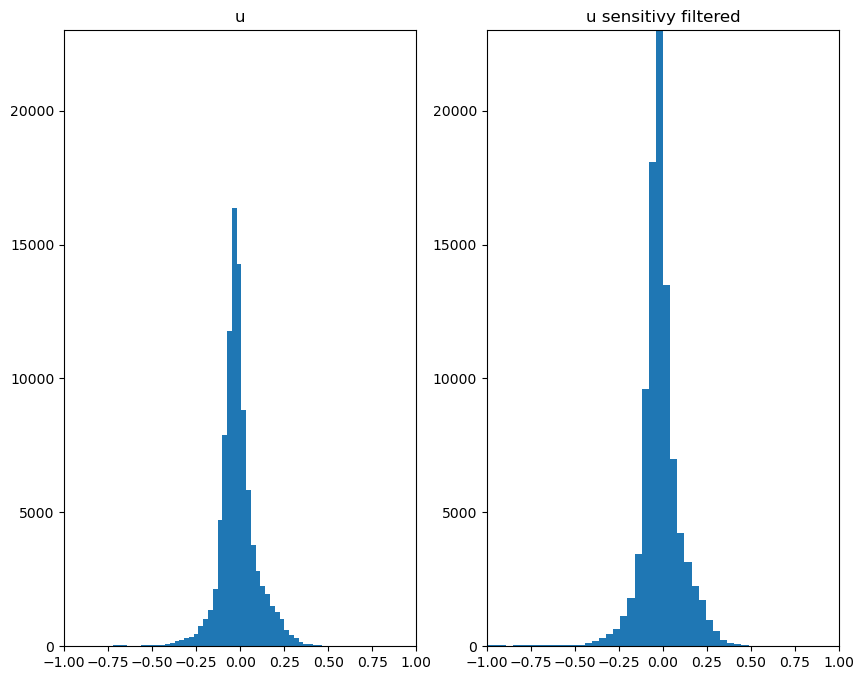

In [5]:
plt.subplot(1, 2, 1)
plt.hist(u[np.where(u!=0)].flatten(), bins=100)
plt.ylim(0, 23000)
plt.xlim(-1, 1)
plt.title('u')
plt.subplot(1, 2, 2)
plt.hist(u_sensitivities[np.where(u!=0)].flatten(), bins=100)
plt.title('u sensitivy filtered')
plt.ylim(0, 23000)
plt.xlim(-1, 1)

## test different box averaging strategies

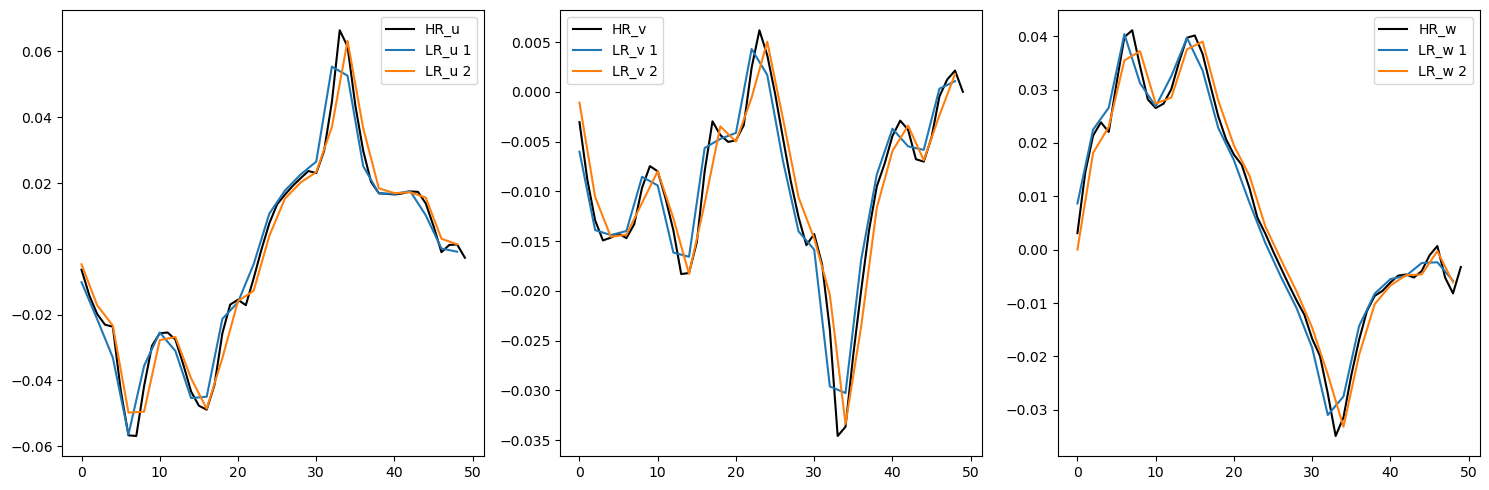

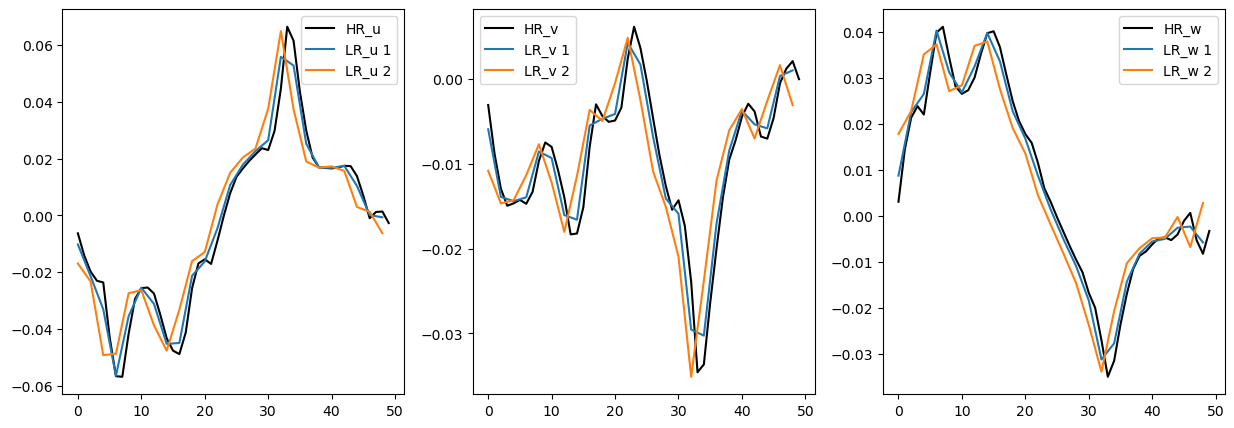

In [2]:
from prepare_data.temporal_downsampling import temporal_box_averaging_and_downsampling

data_dir = '../../data/CARDIAC/'
hr_box_path = 'M4_2mm_step2_cloudmagnRot_boxavg_HRfct.h5'
lr_box_path = 'M4_2mm_step2_cloudmagnRot_boxavg_LRfct_noise.h5'
hrhr_box_path = 'M4_2mm_step1_static_dynamic.h5'

lr_data = {}
hr_data = {}
with h5py.File(f'{data_dir}{hr_box_path}', 'r') as f:
    for k in f.keys():
        hr_data[k] = np.array(f[k]).squeeze()
with h5py.File(f'{data_dir}{lr_box_path}', 'r') as f:
    for k in f.keys():
        lr_data[k] = np.array(f[k]).squeeze()


plt.figure(figsize=(15, 5))

vel_colnames = ['u', 'v', 'w']
for i, vel in enumerate(vel_colnames):
    plt.subplot(1, 3, i+1)
    t_range = range(0, hr_data[vel].shape[0])
    plt.plot(t_range, np.average(hr_data[vel], axis=(1, 2, 3),weights = lr_data['mask']), label=f'HR_{vel}', color = 'black')
    plt.plot(t_range[::2], np.average(lr_data[vel][::2], axis=(1, 2, 3),weights = lr_data['mask'][::2]), label=f'LR_{vel} 1')
    plt.plot(t_range[::2], np.average(lr_data[vel][1::2], axis=(1, 2, 3),weights = lr_data['mask'][::2]), label=f'LR_{vel} 2')


    plt.legend()

plt.tight_layout()
plt.show()

hrhr_data = {}
# part 2: self sampling
with h5py.File(f'{data_dir}{hrhr_box_path}', 'r') as f:
    for k in f.keys():
        hrhr_data[k] = np.array(f[k]).squeeze()

# compute new averages
new_box_avg = {}    
u_box_avg_lr1, u_box_avg_lr2 = temporal_box_averaging_and_downsampling(hrhr_data['u'], 4)
v_box_avg_lr1, v_box_avg_lr2 = temporal_box_averaging_and_downsampling(hrhr_data['v'], 4)
w_box_avg_lr1, w_box_avg_lr2 = temporal_box_averaging_and_downsampling(hrhr_data['w'], 4)

new_box_avg['u1'] = u_box_avg_lr1
new_box_avg['u2'] = u_box_avg_lr2
new_box_avg['v1'] = v_box_avg_lr1
new_box_avg['v2'] = v_box_avg_lr2
new_box_avg['w1'] = w_box_avg_lr1
new_box_avg['w2'] = w_box_avg_lr2

plt.figure(figsize=(15, 5))

for i, vel in enumerate(vel_colnames):
    plt.subplot(1, 3, i+1)
    t_range = range(0, hr_data[vel].shape[0])
    plt.plot(t_range, np.average(hr_data[vel], axis=(1, 2, 3),weights = hr_data['mask']), label=f'HR_{vel}', color = 'black')


    plt.plot(t_range[::2], np.average(new_box_avg[f'{vel}1'], axis=(1, 2, 3),weights = lr_data['mask'][::2]), label=f'LR_{vel} 1')
    plt.plot(t_range[::2], np.average(new_box_avg[f'{vel}2'], axis=(1, 2, 3),weights = lr_data['mask'][::2]), label=f'LR_{vel} 2')


    plt.legend()


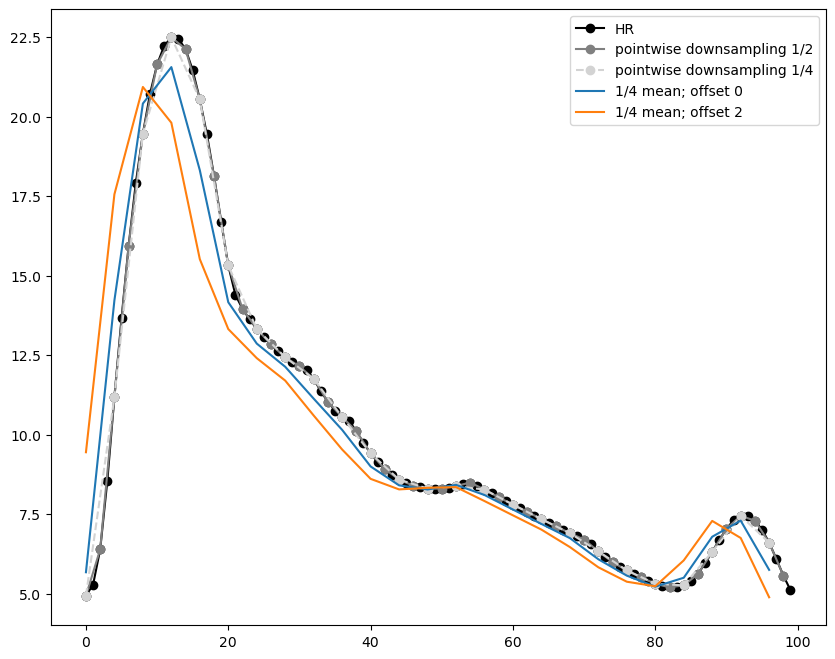

In [7]:
file = "../../data/CARDIAC/M1_2mm_step1_static_dynamic.h5"
vel_colnames = ['u', 'v', 'w']

data = {}
with h5py.File(file, 'r') as f:
    for key in f.keys():
        data[key] = np.array(f[key]).squeeze()


N_frames, x, y, z = data['u'].shape

N_frames_25 = int(N_frames/4)

sampling_1 = np.zeros((N_frames_25, x, y, z, 3))
sampling_2 = np.zeros((N_frames_25, x, y, z, 3))
sampling_3 = np.zeros((N_frames_25, x, y, z, 3))
sampling_4 = np.zeros((N_frames_25, x, y, z, 3))
sampling_5 = np.zeros((N_frames_25, x, y, z, 3))
sampling_6 = np.zeros((N_frames_25, x, y, z, 3))

# there are 6 or actually 7 different sanpling strategies
for v, vel in enumerate(vel_colnames):
    # append the first 4 frames to the end to include periodic boundaries
    data_vel = np.concatenate((data[vel],data[vel][0:4]), axis=0)
    for i in range(N_frames_25):
        
        sampling_1[i, :, :, :, v] = np.average(data_vel[4*i:4*i+4], axis=0)
        sampling_2[i, :, :, :, v] = np.average(data_vel[4*i+1:4*i+5], axis=0)

        sampling_3[i, :, :, :, v] = np.average(data_vel[4*i+2:4*i+6], axis=0)
        sampling_4[i, :, :, :, v] = np.average(data_vel[4*i+3:4*i+7], axis=0)
        sampling_5[i, :, :, :, v] = 0.5 * (data_vel[4*i] + data_vel[4*i+2])
        sampling_6[i, :, :, :, v] = 0.5 * (data_vel[4*i+2] + data_vel[4*i+4])

    # sampling_3=  np.roll(sampling_3, axis=0, shift=1)
    # sampling_4=  np.roll(sampling_4, axis=0, shift=1)

# caluculcate mean speed
mean_speed1 = calculate_mean_speed(sampling_1[:,:, :, :, 0 ], sampling_1[:,:, :, :, 1 ], sampling_1[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed2 = calculate_mean_speed(sampling_2[:,:, :, :, 0 ], sampling_2[:,:, :, :, 1 ], sampling_2[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed3 = calculate_mean_speed(sampling_3[:,:, :, :, 0 ], sampling_3[:,:, :, :, 1 ], sampling_3[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed4 = calculate_mean_speed(sampling_4[:,:, :, :, 0 ], sampling_4[:,:, :, :, 1 ], sampling_4[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed5 = calculate_mean_speed(sampling_5[:,:, :, :, 0 ], sampling_5[:,:, :, :, 1 ], sampling_5[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed6 = calculate_mean_speed(sampling_6[:,:, :, :, 0 ], sampling_6[:,:, :, :, 1 ], sampling_6[:,:, :, :, 2 ], binary_mask=data['mask'][::4])

hr_mean_speed = calculate_mean_speed(data['u'], data['v'], data['w'], binary_mask=data['mask'])

t_range = np.arange(0, N_frames, 4)
t_range_hr = np.arange(0, N_frames)
plt.plot(t_range_hr,hr_mean_speed,'-o',  label='HR', color = 'black')
plt.plot(t_range_hr[::2], calculate_mean_speed(data['u'][::2], data['v'][::2], data['w'][::2], binary_mask=data['mask'][::2]),'o-', label='pointwise downsampling 1/2', color = 'grey')
plt.plot(t_range_hr[::4], calculate_mean_speed(data['u'][::4], data['v'][::4], data['w'][::4], binary_mask=data['mask'][::4]),'o--', label='pointwise downsampling 1/4', color = 'lightgrey')

plt.plot(t_range, mean_speed1, label='1/4 mean; offset 0')
# plt.plot(t_range, mean_speed2, label='1/4 mean; offset 1')
plt.plot(t_range, mean_speed3, label='1/4 mean; offset 2')
# plt.plot(t_range, mean_speed4, label='1/4 mean; offset 3')
# plt.plot(t_range, mean_speed5, label='5')
# plt.plot(t_range[1:], mean_speed6[:-1], label='6')
plt.legend()


In [6]:

dynamical_mask      = '../data/CARDIAC/M4_2mm_step2_static_dynamic.h5'#'../data/PIA/THORAX/P01/h5/P01.h5'#'../data/CARDIAC/M2_2mm_step2_static_dynamic.h5'
noisy_downsampled   = '../data/CARDIAC/M4_2mm_step2_static_dynamic_noise.h5'
# dynamical_mask = '../data/CARDIAC/M2_2mm_step2_invivoP04_magnitude.h5'
# noisy_downsampled = '../data/CARDIAC/M2_2mm_step2_invivoP04_magnitude_noisy.h5'
data_original = {}
data_2 = {}
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = [ 'mag_u', 'mag_v', 'mag_w']
vencs = {}

with h5py.File(dynamical_mask, mode = 'r' ) as p1:
    with h5py.File(noisy_downsampled, mode = 'r' ) as p2:
            print(p1.keys())
            mask =  np.asarray(p1['mask'])
            temporal_mask = mask.copy()
            data_original['mask'] = temporal_mask
            data_2['mask'] = np.asarray(p2['mask']).squeeze()#create_temporal_mask(np.asarray(p2['mask']).squeeze(), p2['u'].shape[0])
            # temporal_mask = create_temporal_mask(mask.squeeze(), p1['u'].shape[0])
            for vel, venc, mag in zip(vel_colnames, venc_colnames, mag_colnames):
                data_original[vel] = np.asarray(p1[vel])#/np.max(p1[venc])
                data_2[vel] = np.asarray(p2[vel])#/np.max(p1[venc])

                data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)
                data_2[f'{vel}_fluid']  = np.multiply(data_2[vel] , temporal_mask)
                data_original[mag] = np.asarray(p1[mag])
                data_2[mag] = np.asarray(p2[mag])

           

print(data_original['mask'].shape, data_2['mask'].shape)
# with h5py.File('../results/Temporal4DFlowNet_20230313-0951/Testset_result_model4_2mm_step2_0951_temporal.h5', mode = 'r' ) as test1:
#      print(test1['u_combined'].shape)

N_frames = data_original['u'].shape[0]
print("Max val:", np.max(data_original['u']), np.max(data_original['v']), np.max(data_original['w']))
print("Min val:", np.min(data_original['u']), np.min(data_original['v']), np.min(data_original['w']))

<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
(50, 62, 58, 84) (50, 62, 58, 84)
Max val: 1.3767313 0.7069674 0.5786051
Min val: -1.0854731 -0.80273545 -1.4435142


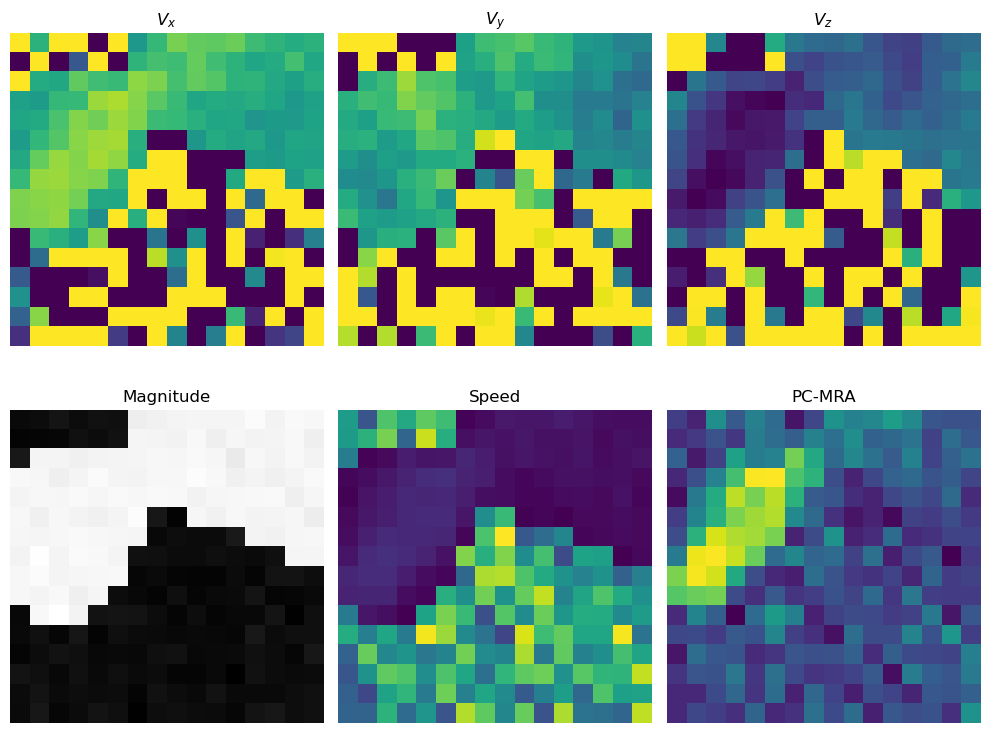

(-0.5, 15.5, 15.5, -0.5)

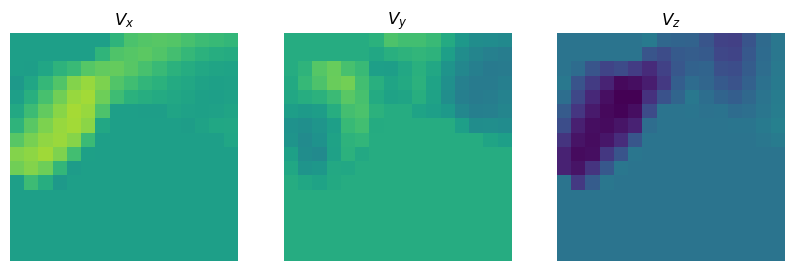

In [7]:
magn = np.sqrt(data_2['mag_u']**2 + data_2['mag_v']**2 + data_2['mag_w']**2)
speed = np.sqrt(data_2['u']**2 + data_2['v']**2 + data_2['w']**2)
pc_mri = np.multiply(magn, speed)

min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

idx_slice = np.index_exp[5, -30:-14, 30, 3:19]


plt.subplot(2, 3, 1)
plt.imshow(data_2['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.title(r'$V_x$')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(data_2['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.title(r'$V_y$')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(data_2['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.title(r'$V_z$')
plt.axis('off')



plt.subplot(2, 3, 4)
plt.imshow(magn[idx_slice], cmap='Greys_r')
plt.title('Magnitude')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(speed[idx_slice])
plt.title('Speed')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(pc_mri[idx_slice])
plt.title('PC-MRA')
plt.axis('off')


plt.tight_layout()
plt.show()

plt.subplot(2, 3, 1)
plt.imshow(data_original['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.title(r'$V_x$')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(data_original['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.title(r'$V_y$')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(data_original['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.title(r'$V_z$')
plt.axis('off')


In [8]:
bounds, core = get_boundaries(data_original['mask'])
speed_data_original = np.sqrt(data_original['u']**2 + data_original['v']**2 + data_original['w']**2)
data_original['speed'] = np.sqrt(data_original['u']**2 + data_original['v']**2 + data_original['w']**2)
print(f'Shapes: {bounds.shape}, {core.shape}, {speed.shape}')

# print(f'sum core: {np.sum(core, axis=(1, 2, 3))}, sum bounds: {np.sum(bounds, axis = (1, 2, 3))}')

# print(f'Mean speed core: {np.mean(speed, axis=(1, 2, 3), where=core.astype(bool))}')
# print(f'Mean speed boundary: {np.mean(speed, axis=(1, 2, 3), where=bounds.astype(bool))}')

print(f'Max Mean speed core: {np.max(np.mean(speed_data_original, axis=(1, 2, 3), where=core.astype(bool)))}')
print(f'Max Mean speed boundary: {np.max(np.mean(speed_data_original, axis=(1, 2, 3), where=bounds.astype(bool)))}')

mean_speed = calculate_mean_speed(data_original['u'], data_original['v'], data_original['w'], data_original['mask'])

plt.plot(np.mean(speed_data_original, axis=(1, 2, 3), where=core.astype(bool)), label='core')
plt.plot(np.mean(speed_data_original, axis=(1, 2, 3), where=bounds.astype(bool)), label='bounds')
plt.plot(np.mean(speed_data_original, axis=(1, 2, 3), where=data_original['mask'].astype(bool)), label='mask')
plt.plot(mean_speed/100, label='mean speed')
plt.legend()

mask_bool = data_original['mask'].astype(bool)
mask = data_original['mask'].copy()

# print(f'difference mean speed caluclations: {np.mean(speed_data_original, axis=(1, 2, 3), where=mask_bool)- mean_speed/100}')
print(f'mean speed core max/ min {np.max(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], core))}, {np.min(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], core))}')
print(f'mean speed bounds max/ min {np.max(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], bounds))}, {np.min(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], bounds))}')
print(f'mean speed mask max/ min {np.max(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], mask))}, {np.min(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], mask))}')

print(f'max speed core {np.multiply(speed_data_original, core).max()} min speed core {np.multiply(speed_data_original, core).min()}')
print(f'max speed bounds {np.multiply(speed_data_original, bounds).max()} min speed bounds {np.multiply(speed_data_original, bounds).min()}')


NameError: name 'get_boundaries' is not defined

### Make data plot

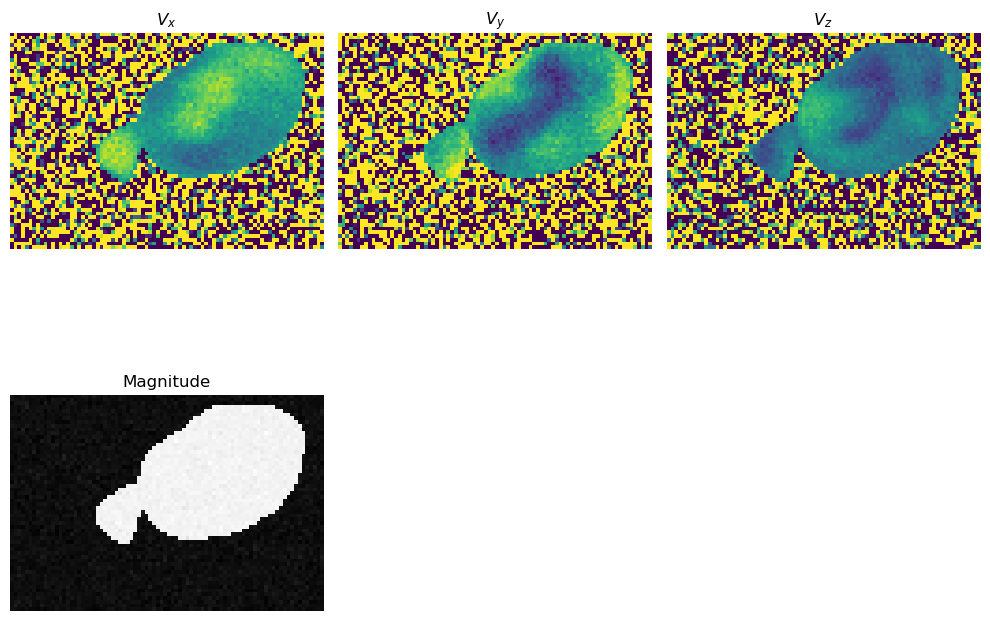

In [9]:
idx_slice = np.index_exp[5, 15, :, :]


plt.subplot(2, 3, 1)
plt.imshow(data_2['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.title(r'$V_x$')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(data_2['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.title(r'$V_y$')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(data_2['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.title(r'$V_z$')
plt.axis('off')



plt.subplot(2, 3, 4)
plt.imshow(magn[idx_slice], cmap='Greys_r')
plt.title('Magnitude')
plt.axis('off')


plt.tight_layout()

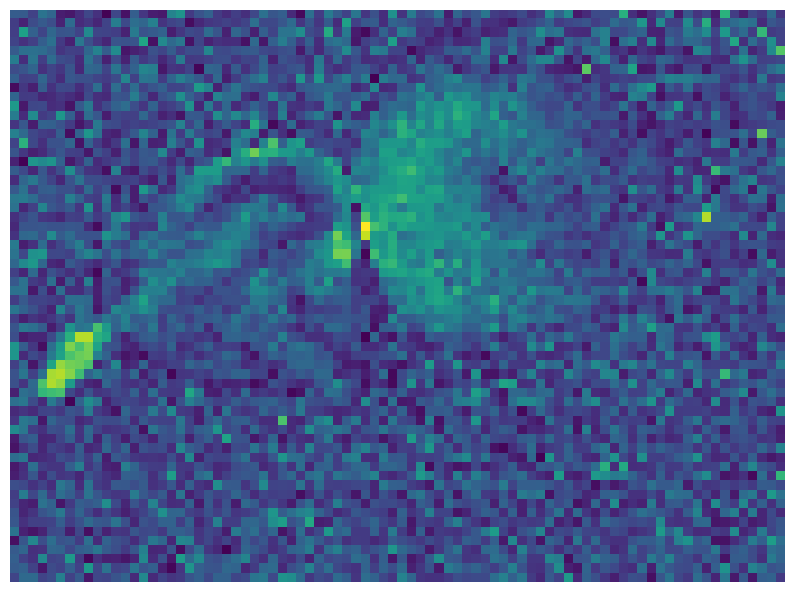

In [11]:
eval_dir = '../results/data'

idx_slice = np.index_exp[5, :, 30, :]


plt.imshow(data_2['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_u.png', bbox_inches='tight')


plt.imshow(data_2['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_v.png',bbox_inches='tight')


plt.imshow(data_2['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_w.png', bbox_inches='tight')


plt.imshow(magn[idx_slice], cmap='Greys_r')
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_mag.png', bbox_inches='tight')

plt.imshow(speed[idx_slice])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_speed.png', bbox_inches='tight')

plt.imshow(pc_mri[idx_slice])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_pcmri.png', bbox_inches='tight')

In [ ]:
frame_i = 10
u1_i_fluid = data_original['u'][frame_i][np.where(data_original['mask'][frame_i] ==1)]
u2_i_fluid = data_2['u'][frame_i][np.where(data_original['mask'][frame_i] ==1)]
# print(u1_i_fluid.shape)
# print('gt SNR:',        signaltonoise(normalize_to_0_1(u1_i_fluid), axis=(0)))
# print('noisy SNR :',    signaltonoise(normalize_to_0_1(u2_i_fluid), axis=(0)))
# print('gt SNR db:',     signaltonoise_db(normalize_to_0_1(u1_i_fluid), axis=(0)))
# print('noisy SNR db:',  signaltonoise_db(normalize_to_0_1(u2_i_fluid), axis=(0)))


# print('PSNR db:', peak_signal_to_noise_ratio(data_1['u'][10], data_2['u'][10]), cv2_psnr(data_1['u'][10], data_2['u'][10]))

# print('SNR :', signaltonoise(data_1['u'][10], axis=(0, 1, 2)))
# snr_u_gt =    [signaltonoise_fluid_region(data_1['u'][frame], data_1['mask'][frame]) for frame in range(N_frames)]
# snr_v_gt =    [signaltonoise_fluid_region(data_1['v'][frame], data_1['mask'][frame]) for frame in range(N_frames)]
# snr_w_gt =    [signaltonoise_fluid_region(data_1['w'][frame], data_1['mask'][frame]) for frame in range(N_frames)]

snr_u_noisy = [signaltonoise_fluid_region(data_2['u'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
snr_v_noisy = [signaltonoise_fluid_region(data_2['v'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
snr_w_noisy = [signaltonoise_fluid_region(data_2['w'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
plt.figure(figsize=(8, 4))

plt.plot(snr_u_noisy,'--', label= 'u noisy')
plt.plot(snr_v_noisy,'--', label= 'v noisy')
plt.plot(snr_w_noisy,'--', label= 'w noisy')
# plt.plot(snr_u_gt,  label= 'u gt')
# plt.plot(snr_v_gt,  label= 'v gt')
# plt.plot(snr_w_gt,  label= 'w gt')
plt.legend()
plt.xlabel('frame')
plt.ylabel('SNR mean/std')

In [ ]:
# look at sinc interpolation
upsampled_sinc ='../data/CARDIAC/M4_2mm_step2_static_dynamic_noise_sinc.h5'
noisy_downsampled = '../data/CARDIAC/M4_2mm_step2_static_dynamic_noise.h5'
data_original = {}
data_2 = {}
vel_colnames = ['u', 'v','w']

with h5py.File(noisy_downsampled, mode = 'r' ) as p1:
    data_original['mask'] =  np.asarray(p1['mask'])
    temporal_mask = np.asarray(data_original['mask']).squeeze().copy()
    for vel in vel_colnames:
        data_original[vel] = np.asarray(p1[vel])
        data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)

with h5py.File(upsampled_sinc, mode = 'r' ) as p2:
    data_2['mask'] =  temporal_mask
    for vel in vel_colnames:
        data_2[vel] = np.asarray(p2[vel]).squeeze()



[ 0.00000000e+00  1.11111111e-01  2.22222222e-01  3.33333333e-01
  4.44444444e-01  5.55555556e-01  6.66666667e-01  7.77777778e-01
 -1.11111111e-01  5.55111512e-17]
[ 0.00000000e+00  1.11111111e-01  2.22222222e-01  3.33333333e-01
  4.44444444e-01  5.55555556e-01  6.66666667e-01  7.77777778e-01
 -1.11111111e-01  5.55111512e-17]
[ 0.00000000e+00  1.11111111e-01  2.22222222e-01  3.33333333e-01
  4.44444444e-01  5.55555556e-01  6.66666667e-01  7.77777778e-01
 -1.11111111e-01  5.55111512e-17]
[ 0.00000000e+00  1.11111111e-01  2.22222222e-01  3.33333333e-01
  4.44444444e-01  5.55555556e-01  6.66666667e-01  7.77777778e-01
 -1.11111111e-01  5.55111512e-17]
[ 0.00000000e+00  1.11111111e-01  2.22222222e-01  3.33333333e-01
  4.44444444e-01  5.55555556e-01  6.66666667e-01  7.77777778e-01
 -1.11111111e-01  5.55111512e-17]
[ 0.00000000e+00  1.11111111e-01  2.22222222e-01  3.33333333e-01
  4.44444444e-01  5.55555556e-01  6.66666667e-01  7.77777778e-01
 -1.11111111e-01  5.55111512e-17]
[ 0.00000000e+00

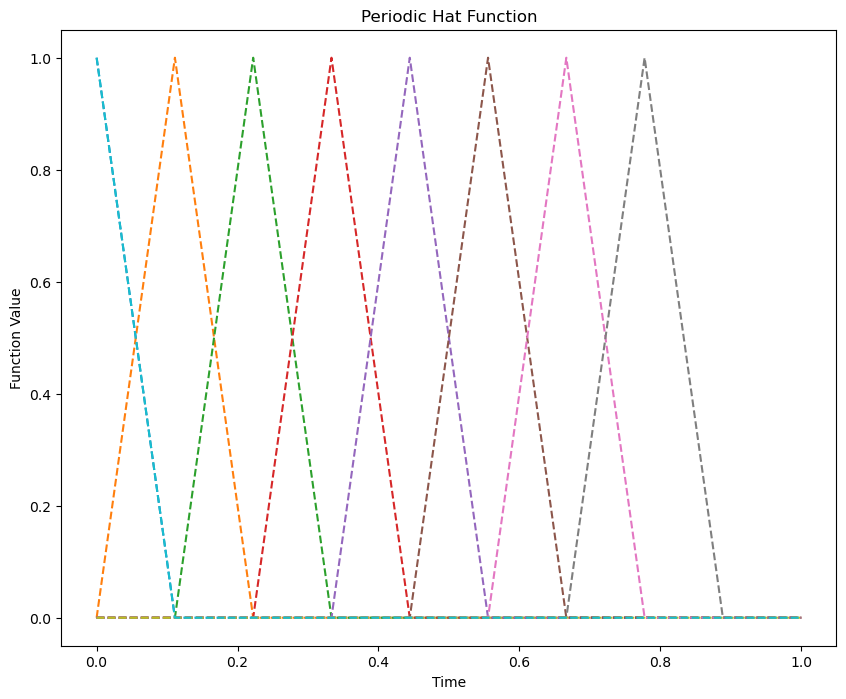

In [49]:
def make_periodic(func, t, interval, *args, **kwargs):
    t_shifted = (t - (interval[0] - dt)) % (interval[1] - interval[0]) + (interval[0] - dt)
    print(t_shifted)
    return func(t_shifted, *args, **kwargs)

# Example usage with the hat function
def hat_function(t, width):
    return np.where((t >= 0) & (t < width/2), t/(width/2), np.where((t >= width/2) & (t < width), 1 - (t-width/2)/(width/2), 0))

def smoothed_box_fct(t, t0, w, sigma):
            """
            Smoothed box function. With alpha = 1 this is not normalized to 1
            """
            non_normalized = (1/(1+np.exp(-(t-(t0-w/2))/sigma)) - 1/(1+np.exp(-(t-(t0+w/2))/sigma)))
            alpha = 1
            # alpha = 1/integral_trapez(non_normalized, t)
            return alpha * non_normalized

# Example usage:
time_points = np.linspace(0, 1, 10)  # Time points from 0 to 1
interval = [0, 1]  # Specify the interval
width = 0.2  # Adjust width of the hat function as needed

smoothing = 0.004
dt = time_points[1] - time_points[0]

results = [make_periodic(smoothed_box_fct, time_points, interval, t_n, dt, smoothing) for t_n in time_points]


print(-0.1%1)
# Plot the result
plt.plot(time_points, results, "--")
plt.title('Periodic Hat Function')
plt.xlabel('Time')
plt.ylabel('Function Value')
plt.show()


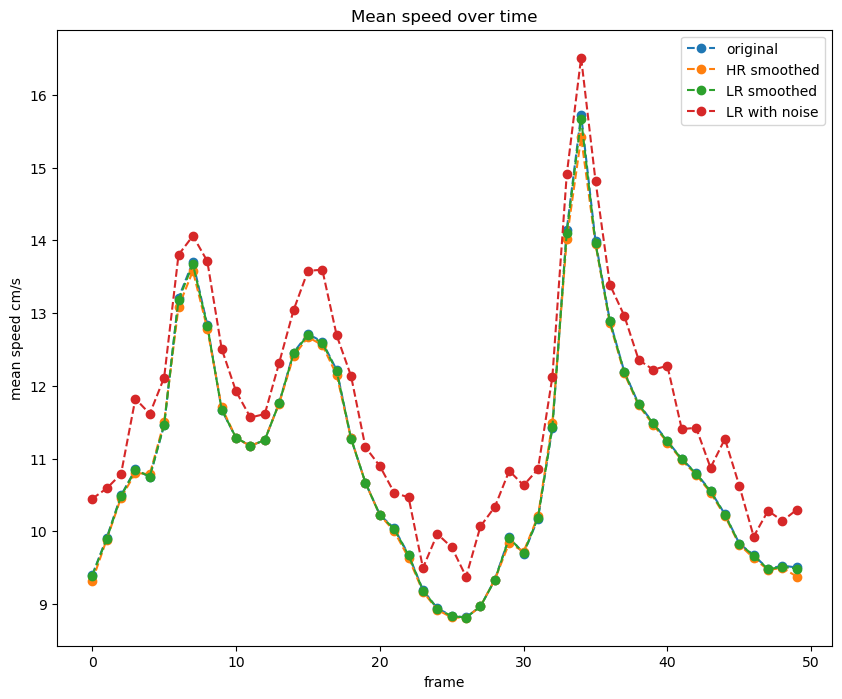

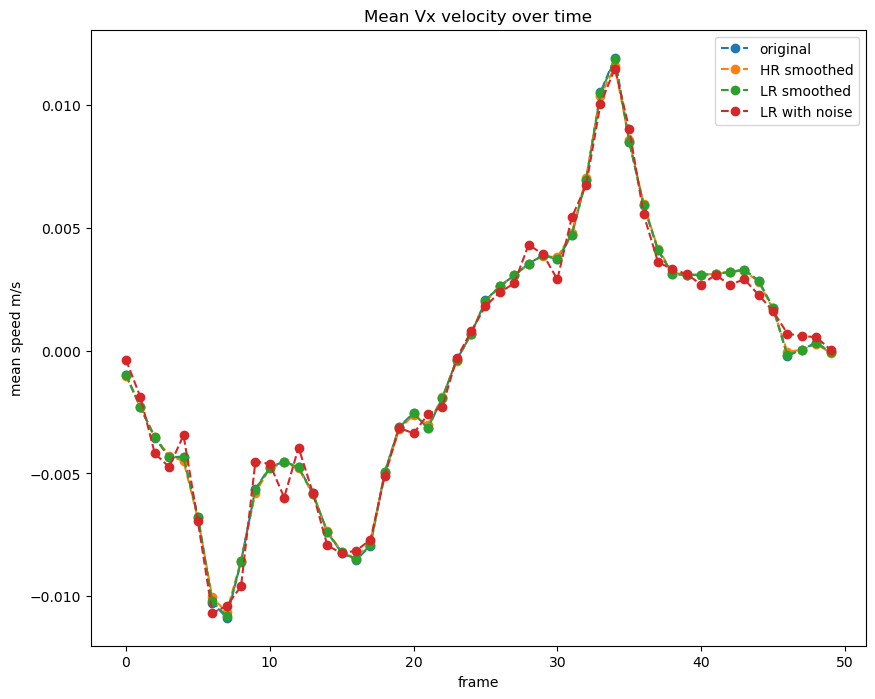

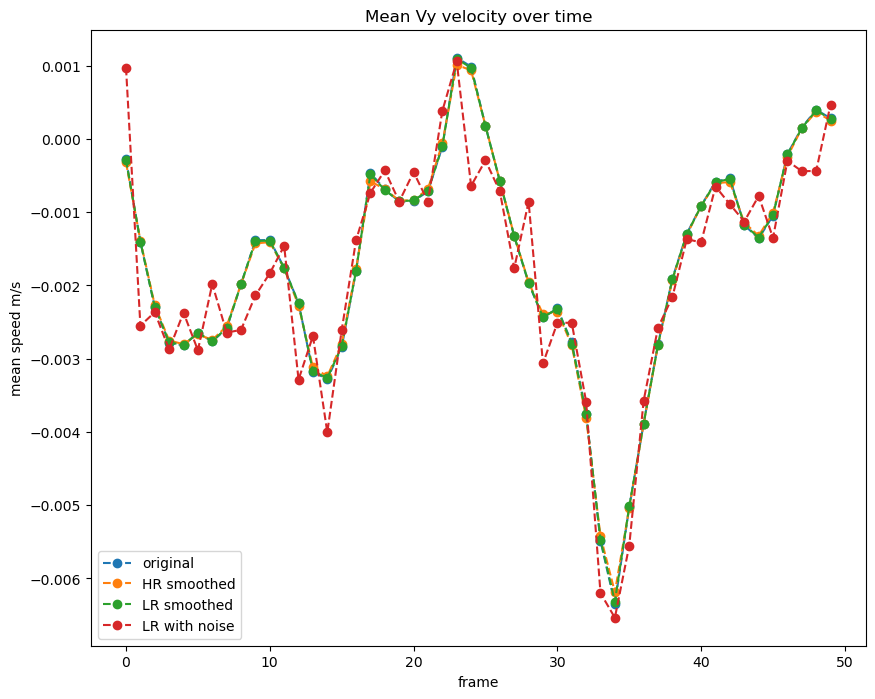

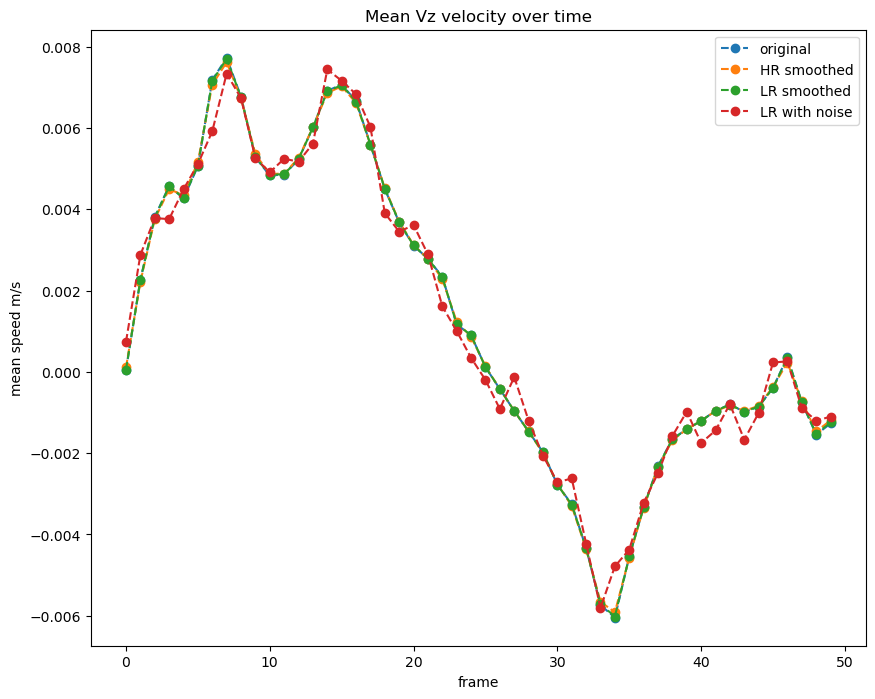

In [3]:
# load orginial data, HR smoothed and LR smoothed

# plot mean speed over time and mean velocitty over time

orginial_HR = '../data/CARDIAC/M4_2mm_step2_static_dynamic.h5'
HR_smmoothed = '../data/CARDIAC/M4_2mm_step2_temporalsmoothing_toeger_periodic_HRfct.h5'
LR_smmoothed = '../data/CARDIAC/M4_2mm_step2_temporalsmoothing_toeger_periodic_LRfct.h5'
LR_with_noise = '../data/CARDIAC/M4_2mm_step2_temporalsmoothing_toeger_periodic_LRfct_noise.h5'



data_original = {}
data_HR = {}
data_LR = {}
data_LR_with_noise = {}
vel_colnames = ['u', 'v','w']

# load data
with h5py.File(orginial_HR, mode = 'r' ) as p1:
    with h5py.File(HR_smmoothed, mode = 'r' ) as p2:
        with h5py.File(LR_smmoothed, mode = 'r' ) as p3:
            with h5py.File(LR_with_noise, mode = 'r' ) as p4:
                data_original['mask'] =  np.asarray(p1['mask'])
                temporal_mask = np.asarray(data_original['mask']).squeeze().copy()
                for vel in vel_colnames:
                    data_original[vel] = np.asarray(p1[vel])
                    data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)

                    data_HR[vel] = np.asarray(p2[vel])
                    data_HR[f'{vel}_fluid'] = np.multiply(data_HR[vel], temporal_mask)

                    data_LR[vel] = np.asarray(p3[vel])
                    data_LR[f'{vel}_fluid'] = np.multiply(data_LR[vel], temporal_mask)

                    data_LR_with_noise[vel] = np.asarray(p4[vel])
                    data_LR_with_noise[f'{vel}_fluid'] = np.multiply(data_LR_with_noise[vel], temporal_mask)




# calculate mean speed
mean_speed_originalHR   = calculate_mean_speed(data_original['u'], data_original['v'], data_original['w'], data_original['mask'])
mean_speed_HR_smoothed  = calculate_mean_speed(data_HR['u'], data_HR['v'], data_HR['w'], data_original['mask'])
mean_speed_LR_smoothed  = calculate_mean_speed(data_LR['u'], data_LR['v'], data_LR['w'], data_original['mask'])
mean_speed_LR_with_noise  = calculate_mean_speed(data_LR_with_noise['u'], data_LR_with_noise['v'], data_LR_with_noise['w'], data_original['mask'])

plt.plot(mean_speed_originalHR, 'o--', label='original')
plt.plot(mean_speed_HR_smoothed,'o--', label='HR smoothed')
plt.plot(mean_speed_LR_smoothed,'o--', label='LR smoothed')
plt.plot(mean_speed_LR_with_noise,'o--', label='LR with noise')
plt.legend()
plt.xlabel('frame')
plt.ylabel('mean speed cm/s')
plt.title('Mean speed over time')
plt.show()

# compare Vx velocity

plt.plot(np.mean(data_original['u'], axis=(1, 2, 3)), 'o--', label='original')
plt.plot(np.mean(data_HR['u'], axis=(1, 2, 3)), 'o--', label='HR smoothed')
plt.plot(np.mean(data_LR['u'], axis=(1, 2, 3)), 'o--', label='LR smoothed')
plt.plot(np.mean(data_LR_with_noise['u'], axis=(1, 2, 3)), 'o--', label='LR with noise')
plt.legend()
plt.xlabel('frame')
plt.ylabel('mean speed m/s')
plt.title('Mean Vx velocity over time')
plt.show()

# compare Vy velocity

plt.plot(np.mean(data_original['v'], axis=(1, 2, 3)), 'o--', label='original')
plt.plot(np.mean(data_HR['v'], axis=(1, 2, 3)), 'o--', label='HR smoothed')
plt.plot(np.mean(data_LR['v'], axis=(1, 2, 3)), 'o--', label='LR smoothed')
plt.plot(np.mean(data_LR_with_noise['v'], axis=(1, 2, 3)), 'o--', label='LR with noise')
plt.legend()
plt.xlabel('frame')
plt.ylabel('mean speed m/s')
plt.title('Mean Vy velocity over time')
plt.show()

# compare Vz velocity

plt.plot(np.mean(data_original['w'], axis=(1, 2, 3)), 'o--', label='original')
plt.plot(np.mean(data_HR['w'], axis=(1, 2, 3)), 'o--', label='HR smoothed')
plt.plot(np.mean(data_LR['w'], axis=(1, 2, 3)), 'o--', label='LR smoothed')
plt.plot(np.mean(data_LR_with_noise['w'], axis=(1, 2, 3)), 'o--', label='LR with noise')
plt.legend()
plt.xlabel('frame')
plt.ylabel('mean speed m/s')
plt.title('Mean Vz velocity over time')
plt.show()


## Blochs equations


In [167]:
from scipy.integrate import odeint, solve_ivp, complex_ode
from mpl_toolkits.mplot3d import Axes3D

# Define Bloch equations
def bloch_equations(t, y, B0, gamma, T1, T2, M0):
    """ Bloch equation where V = 0 
    """
    assert T2 < T1, "T2 relaxation must be faster than T1 relaxation"

    Mx, My, Mz = y
    omega = gamma * B0
    Bgz = 1
    B1 = 1
    B1x = B1* np.cos(omega * t)
    B1y = -B1* np.sin(omega * t)


    dMxdt = omega * (My*Bgz - Mz*B1y) - Mx/ T2
    dMydt = omega * (Mz*B1x - Mx*Bgz) -(My / T2)
    dMzdt = omega * (Mx*B1y - My*B1x) -(Mz - M0) / T1 

    return [dMxdt, dMydt, dMzdt]

# Bloch-Gleichungen
def bloch_equations_2(t, y, gamma, B0, T1, T2):
    mx, my, mz = y
    omega = gamma * B0

    dmxdt = omega * my - mx / T2
    dmydt = -omega * mx - my / T2
    dmzdt = (1 - mz) / T1 - omega * mx

    return [dmxdt, dmydt, dmzdt]


# Parameters
B0 = 1.5  # Magnetic field strength in Tesla
gamma = 267538030.3797/B0#42.58e6  # Gyromagnetic ratio for protons in rad/(s*T)
T1 = 0.005  # Longitudinal relaxation time in seconds
T2 = 0.002 # Transverse relaxation time in seconds

# Initial magnetization
y0 = [1.0, 0.0, 0.0]  # Ensure M0 is a flat, one-dimensional array
M0 = 7.0
# Time points
t = np.linspace(0, 0.1, 1001)

# Solve Bloch equations
solution = complex_ode(bloch_equations, y0, t, args=(B0, gamma, T1, T2, M0), )

t_span = (0, 2.0)  # Start- und Endzeit
t_eval = np.linspace(*t_span, 1000)  # Zeitpunkte für die Auswertung

# Lösung der Bloch-Gleichungen
# solution = solve_ivp(
#     bloch_equations,
#     t_span,
#     y0,
#     args=(gamma, B0, T1, T2, M0),
#     t_eval=t_eval,
#     method="RK45",
# )


# Extract components of magnetization
Mx, My, Mz = solution.T

print(Mx, My, Mz)
# Print or use the results as needed

# Plot trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Mx, My, Mz)
ax.set_xlabel('Mx')
ax.set_ylabel('My')
ax.set_zlabel('Mz')
plt.show()



TypeError: __init__() got an unexpected keyword argument 'args'

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  2.002e-03 ...  2.803e-02  3.003e-02]
        y: [[ 1.000e+00  7.542e-03 ...  1.156e+265  5.187e+287]
            [ 0.000e+00 -2.501e-01 ... -2.585e+265  2.472e+287]
            [ 0.000e+00 -2.583e-04 ... -7.955e+264 -3.182e+287]]
      sol: None
 t_events: None
 y_events: None
     nfev: 99982226
     njev: 0
      nlu: 0
(3, 16)
[ 1.00000000e+000  7.54161809e-003 -2.12322874e-003 -1.23551740e+019
 -1.85718250e+040 -1.27276547e+064  7.17627696e+085  6.32501118e+108
 -3.16122663e+129  2.90739173e+153 -3.25789102e+175 -2.04335533e+198
  6.04377661e+219 -6.14499896e+242  1.15572273e+265  5.18703877e+287] [ 0.00000000e+000 -2.50057813e-001 -7.51585960e-005 -1.06405431e+018
  1.55476138e+041 -1.95463007e+063 -3.97202133e+086  1.34748474e+108
  1.24987213e+130  7.91042056e+152  1.06116515e+176 -6.88891095e+197
 -1.59726592e+220 -2.52446489e+242 -2.58473327e+265  2.472225

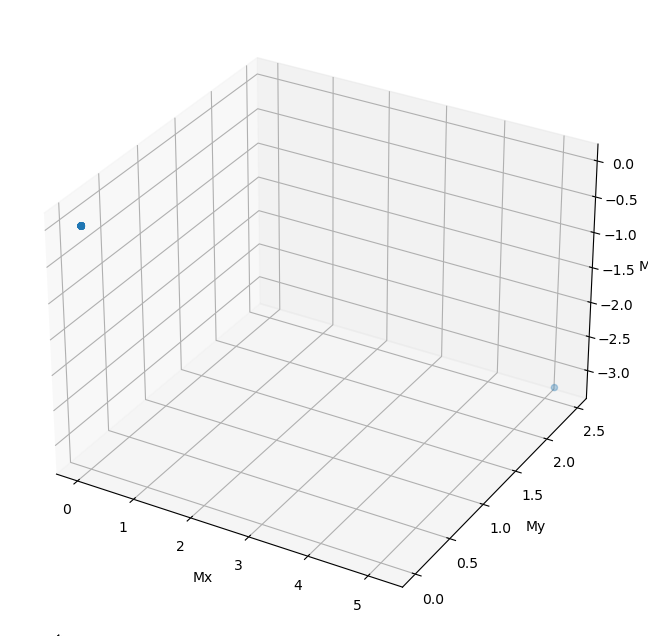

In [161]:
print(solution)
Mx, My, Mz = solution.y

print(solution.y.shape)
print(Mx, My, Mz)
# Print or use the results as needed

# Plot trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Mx, My, Mz)
ax.set_xlabel('Mx')
ax.set_ylabel('My')
ax.set_zlabel('Mz')
plt.show()

[0.0000e+00 3.0000e-05 6.0000e-05 ... 2.9994e-01 2.9997e-01 3.0000e-01]


interactive(children=(FloatSlider(value=0.03, description='T1', max=0.03, min=0.001, step=0.01), FloatSlider(v…

C:\Users\piacal\AppData\Local\Temp\ipykernel_25676\1428582818.py:52: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


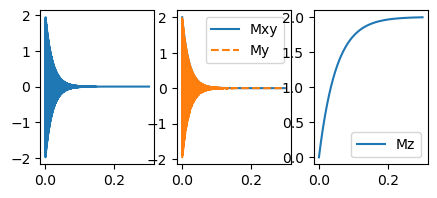

In [3]:
# Parameters
B0 = 1.5  # Magnetic field strength in Tesla
gamma = 42.58e6  # gyromagnetisches Verhältnis für Wasserstoff in Hz/T
T1 = 0.05  # Longitudinal relaxation time in seconds
T2 = 0.02 # Transverse relaxation time in seconds
M0 = 2.0
t = np.linspace(0, 0.3, 10001)
print(t)
A = 1
freq = B0 * gamma	
Mx = M0* np.exp(-t/T2)*np.sin(freq * t)
My = M0*np.exp(-t/T2)* np.cos(freq * t)
Mxy = np.sqrt(Mx**2 + My**2)
Mz = M0*(1- np.exp(-t/T1))
# Bext = np.linspace(0, 10, t.shape[0])

# Plot trajectory in 3D

@widgets.interact(T1=(0.001, 0.03, 0.01), T2=(0.001, 0.03,0.01))
def f(T1 = 0.05, T2=0.02):

    # define Mx, My, Mz
    Mx = M0* np.exp(-t/T2)*np.sin(freq * t)
    My = M0*np.exp(-t/T2)* np.cos(freq * t)
    Mz = M0*(1- np.exp(-t/T1))

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Mx, My, Mz, cmap = 'viridis', c = t)
    ax.plot(Mx, My, Mz)
    ax.set_xlabel('Mx')
    ax.set_ylabel('My')
    ax.set_zlabel('Mz')

    # ax2 = fig.add_subplot(111)
    # ax2.plot(t, Mx, label='Mx')


    plt.show()
    
fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Mx, My, Mz)
ax.scatter(Mx, My, Mz, cmap = 'viridis', c = t)
ax.set_xlabel('Mx')
ax.set_ylabel('My')
ax.set_zlabel('Mz')



plt.subplot(1, 3, 1)
plt.plot(t, Mx, label='Mx')
plt.subplot(1, 3, 2)
plt.plot(t, Mxy,   label='Mxy')
plt.plot(t, My,"--", label='My')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(t, Mz, label='Mz')
plt.legend()

In [106]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Bloch-Gleichungen
def bloch_equations(t, y, gamma, B0, T1, T2):
    mx, my, mz = y
    omega = gamma * B0

    dmxdt = omega * my - mx / T2
    dmydt = -omega * mx - my / T2
    dmzdt = (1 - mz) / T1 - omega * mx

    return [dmxdt, dmydt, dmzdt]

# Simulationsparameter
gamma = 42.58e6  # gyromagnetisches Verhältnis für Wasserstoff in Hz/T
B0 = 3.0  # Stärke des externen Magnetfelds in Tesla
T1 = 1.0  # Längsrelaxationszeit in Sekunden
T2 = 0.1  # Querrelaxationszeit in Sekunden

# Anfangsbedingungen
mx0, my0, mz0 = 1.0, 0.0, 0.0  # Anfangsmagnetisierung in x-Richtung

# Zeitpunkte für die Lösung der Bloch-Gleichungen
t_span = (0, 2.0)  # Start- und Endzeit
t_eval = np.linspace(*t_span, 1000)  # Zeitpunkte für die Auswertung

# Lösung der Bloch-Gleichungen
solution = solve_ivp(
    bloch_equations,
    t_span,
    [mx0, my0, mz0],
    args=(gamma, B0, T1, T2),
    t_eval=t_eval,
    method="RK45",
)

# Plotten des Bloch-Vektor-Diagramms
plt.plot(solution.y[0], solution.y[1])
plt.title("Bloch Vektor Diagramm")
plt.xlabel("$m_x$")
plt.ylabel("$m_y$")
plt.show()


KeyboardInterrupt: 

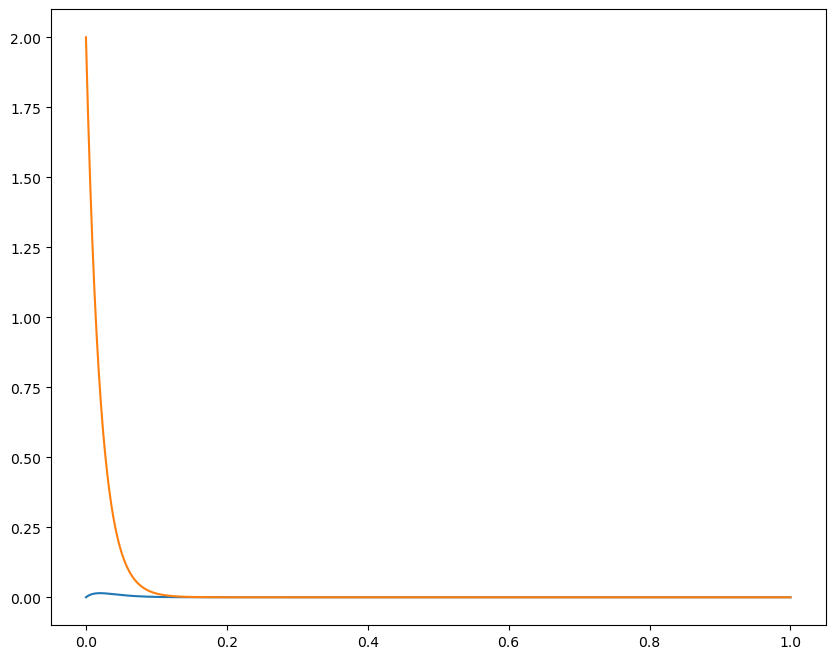

In [138]:
Mx = M0* np.exp(-t/T2)*np.sin(1 * t)
My = M0* np.exp(-t/T2)*np.cos(1 * t)

plt.plot(t, Mx, label='Mx')
plt.plot(t, My, label='My')

In [1]:
print(temporal_mask.shape)
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

NameError: name 'temporal_mask' is not defined

##### Compare temporal smoothing function by toeger to high ressolution data

In [15]:
hr_file = '../data/CARDIAC/M3_2mm_step2_invivoP03_magn_temporalsmoothing_toeger_periodic_HRfct.h5'
temporal_smoothing_file = "../data/CARDIAC/M3_2mm_step2_invivoP03_magn_temporalsmoothing_toeger_periodic_LRfct_noise.h5"

# load data
with h5py.File(hr_file, mode = 'r' ) as p1:
    u_hr = np.asarray(p1['u'])
    mask = np.asarray(p1['mask'])
    # magn = np.asarray(p1['mag_u'])
with h5py.File(temporal_smoothing_file, mode = 'r' ) as p2:
    u_temporal_smoothing = np.asarray(p2['u'])
    magn = np.asarray(p2['mag_u'])
    

#find lower and higher values to display velocity fields
min_v = np.quantile(u_hr[np.where(mask !=0)].flatten(), 0.01)
max_v = np.quantile(u_hr[np.where(mask !=0)].flatten(), 0.99)

# interactive display of velocity fields
@widgets.interact(frame=(0, u_hr.shape[0]-1), x = (0, u_hr.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 4, 1)
    idx_slice = np.index_exp[frame, x, :, :]
    plt.imshow(u_hr[idx_slice], vmin=min_v, vmax=max_v)
    plt.title('hr velocity u')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(u_temporal_smoothing[idx_slice], vmin=min_v, vmax=max_v)
    plt.title('temp smoothing u')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(u_hr[idx_slice] - u_temporal_smoothing[idx_slice],)
    plt.title('diff')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(magn[idx_slice], cmap='Greys_r')
    plt.axis('off')
    plt.title('magnitude')

interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=0, description='x', max…

In [ ]:
A = np.array([1, 2,3 ,4, 5])
print(A[-3:])
periodic_weighting = np.zeros(6)
weightning = np.arange(0, 11)

len_trange = len(periodic_weighting)
len_l = 2
len_r = 3

print(weightning)
print(periodic_weighting)
print(len(periodic_weighting))

periodic_weighting = weightning[len_l:len_l+len_trange] # middle
print(len(periodic_weighting))
periodic_weighting[:len_r] += weightning[-len_r:] 
periodic_weighting[-len_l:] += weightning[:len_l]

print(periodic_weighting)
print(len(periodic_weighting))

[3 4 5]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0. 0. 0. 0. 0. 0.]
6
6
[10 12 14  5  6  8]
6


: 

### In vivo data visualization

In [ ]:
# look at in vivo data
in_vivo = '../data/PIA/BARCELONA/h5/sample_patient_newmask.h5'
# in_vivo_upsampled = '../data/PIA/BARCELONA/h5/sample_patient.h5'
in_vivo_upsampled = '../results/in_vivo/BARCELONA/20230405-1417_temporal.h5' # _newshape
# in_vivo = '../data/PIA/THORAX/P01/h5/P01.h5'
# in_vivo_upsampled = '../results/in_vivo/THORAX/P01_20230405-1417_temporal.h5' #image.png
data_original = {}
data_predicted = {}
vencs = {}
vel_colnames = ['u', 'v','w']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']
venc_colnames = [  'u_max', 'v_max', 'w_max']



#load in-vivo data
with h5py.File(in_vivo, mode = 'r' ) as p1:
    data_original['mask'] =  np.asarray(p1['mask']).squeeze()
    print(p1.keys())
    for vel, venc in zip(vel_colnames, venc_colnames):
        vencs[venc] = np.asarray(p1[venc])
        data_original[vel] = np.asarray(p1[vel], dtype = float).squeeze()/np.max(p1[venc]) #TODO change this
        data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], data_original['mask'])
    for mag in mag_colnames:
         data_original[mag] =  np.asarray(p1[mag]).squeeze()

#load prediction
with h5py.File(in_vivo_upsampled, mode = 'r' ) as h_pred:
    for vel, venc in zip(vel_colnames, venc_colnames):
        data_predicted[vel] = np.asarray(h_pred[f'{vel}_combined']) /np.max(vencs[venc]) 
        # add information considering only the fluid regions  
        data_predicted[f'{vel}_fluid'] =np.multiply(data_predicted[vel], data_original['mask'])
        
# print(data_predicted['u'].shape, data_1['u'].shape)
N_frames = data_original['u'].shape[0]
print("Max val:", np.max(data_original['u']), np.max(data_original['v']), np.max(data_original['w']))
print("Min val:", np.min(data_original['u']), np.min(data_original['v']), np.min(data_original['w']))

# print(np.linalg.norm(data_1['mask']- data_predicted['mask']))

<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
Max val: 1.0 0.9995219885277247 0.961789375582479
Min val: -0.9240053643272239 -1.0 -1.0


In [ ]:

print('pred SNR:', signaltonoise(normalize_to_0_1(data_predicted['u'][10]), axis=(0, 1, 2)))
print('noisy SNR :', signaltonoise(normalize_to_0_1(data_original['u'][10]), axis=(0, 1, 2)))
print('pred SNR db:', signaltonoise_db(normalize_to_0_1(data_predicted['u'][10]), axis=(0, 1, 2)))
print('noisy SNR db:', signaltonoise_db(normalize_to_0_1(data_original['u'][10]), axis=(0, 1, 2)))
snr_u_input = [signaltonoise_db(normalize_to_0_1(data_original['u'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_v_input = [signaltonoise_db(normalize_to_0_1(data_original['v'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_w_input = [signaltonoise_db(normalize_to_0_1(data_original['w'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_u_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['u'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_v_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['v'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_w_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['w'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
plt.figure(figsize=(8, 4))
plt.plot(snr_u_input,'--', label= 'u in-vivo')
plt.plot(snr_v_input,'--', label= 'v in-vivo')
plt.plot(snr_w_input,'--', label= 'w in-vivo')
plt.plot(snr_u_sr, label= 'u predicted')
plt.plot(snr_v_sr, label= 'v predicted')
plt.plot(snr_w_sr, label= 'w predicted')
plt.legend()
plt.xlabel('frame')
plt.ylabel('SNR mean/std')

In [ ]:
def temporal_linear_interpolation_np_test(lr, hr_shape):
    T, x, y, z = hr_shape
    interpolate = np.zeros((hr_shape))
    interpolate[::2, :, :, :] = lr
    for t in range(0, T-2, 2):
        interpolate[1+t, :, :, :] = (interpolate[t, :, :, :] + interpolate[1+t+1, :, :, :]) /2

    return interpolate

In [ ]:
#find lower and higher values to display velocity fields
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(data_original['mask'] !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(data_original['mask'] !=0)].flatten(), 0.99)

In [ ]:


# interpolate data (take every second slice and interpolate them)
interpolate_linear = {}
interpolate_cubic = {}
for vel in vel_colnames:
    interpolate_linear[vel] = temporal_linear_interpolation_np_test(data_original[vel][::2], data_original[vel].shape)
    interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], data_original['mask'])

    # interpolate_cubic[vel] = temporal_cubic_interpolation(data_1[vel][::2], data_1[vel].shape)
    # interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], data_1['mask'])

error_pointwise, error_absolut = calculate_pointwise_error(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])

# visualize given data
magn = np.sqrt(data_original['mag_u']**2 + data_original['mag_v']**2 + data_original['mag_w']**2)

## Visualize in - vivo data

In [ ]:
# look at in vivo data
in_vivo_oldmask = '../data/PIA/BARCELONA/BARCELONA2/h5/case_004.h5'
data_original = {}

#load in-vivo data
with h5py.File(in_vivo_oldmask, mode = 'r' ) as p1:
    for vel in vel_colnames:
        data_original[vel] = np.array(p1[vel]).squeeze() 
    for mag in mag_colnames:
        data_original[mag] = np.array(p1[mag]).squeeze() 
    print(p1.keys())
    data_original['mask'] =  np.asarray(p1['mask']).squeeze()  
    for key in p1.keys():
        print(key, 'shape', p1[key].shape)
    
    # print(np.array(p1['v_max']))

# print('Norm loaded masks:', np.linalg.norm(data_original['mask']- data_original['mask_old']))


@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.figure(figsize=(10, 10))
    N  =3
    plt.subplot(1, N, 1)
    plt.imshow(data_original['u'][frame, x, :, :])#, vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Data, u')
    plt.axis('off')

    # plt.subplot(1, N, 2)
    # plt.imshow(data_original['u_fluid'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    # plt.title('new mask')
    # plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(data_original['mag_u'][frame, x, :, :])
    plt.title('mag')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(data_original['mask'][frame, x, :, :])#-data_original['mask'][frame, x, :, :])
    plt.title('mask')
    plt.axis('off')

    # plt.subplot(1, 4, 3)
    # plt.imshow(magn[frame, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    # plt.title('magnitude')
    # plt.axis('off')

    # plt.subplot(1, 4, 4)
    # plt.imshow(data_1['mask'][frame, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    # plt.title('mask')
    # plt.axis('off')
    # plt.show()

<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
dx shape (1, 3)
mag_u shape (30, 144, 178, 256)
mag_v shape (30, 144, 178, 256)
mag_w shape (30, 144, 178, 256)
mask shape (30, 144, 178, 256)
u shape (30, 144, 178, 256)
u_max shape (30, 1)
v shape (30, 144, 178, 256)
v_max shape (30, 1)
w shape (30, 144, 178, 256)
w_max shape (30, 1)


interactive(children=(IntSlider(value=5, description='frame', max=29), IntSlider(value=0, description='x', max…

In [ ]:
print('Norm loaded masks:', np.linalg.norm(data_original['mask']- data_original['mask_old']))

# make mask from predicted region
mask_predicted = np.zeros_like(data_predicted['v'])
mask_predicted[np.where(data_predicted['v'] !=0)]

print('Norm predicted mask and loaded mask', np.linalg.norm(data_original['mask']- mask_predicted))

#### Show comparison of prediction and original data

In [ ]:

@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    idx_slice = np.index_exp[frame, x, :, :]

    

    plt.subplot(3, 4, 1)
    plt.imshow(data_original['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    # plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title('u')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(data_original['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    # plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title('v')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(data_original['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    # plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title('w')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(data_original['mask'][idx_slice], cmap ='Greys')
    plt.title('mask')
    plt.axis('off')
    
    plt.subplot(3, 4, 5)
    plt.imshow(data_predicted['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title('u predicted')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(data_predicted['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title('v predicted')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(data_predicted['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title('w predicted')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(magn[idx_slice], cmap ='Greys')
    plt.title('magnitude')
    plt.axis('off')

    plt.subplot(3, 4, 9)
    plt.imshow(np.abs(data_original['u_fluid'][idx_slice]- data_predicted['u_fluid'][idx_slice]), vmin = min_v['u'], vmax = max_v['u'], cmap = 'coolwarm')
    plt.title('abs diff u, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(np.abs(data_original['v_fluid'][idx_slice] - data_predicted['v_fluid'][idx_slice]), vmin = min_v['v'], vmax = max_v['v'], cmap = 'coolwarm')
    plt.title('abs diff v, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(np.abs(data_original['w_fluid'][idx_slice] -data_predicted['w_fluid'][idx_slice]), vmin = min_v['w'], vmax = max_v['w'], cmap = 'coolwarm')
    plt.title('abs diff w, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.imshow(error_pointwise[idx_slice], cmap = 'coolwarm')
    plt.title('relative error')
    plt.axis('off')


    plt.tight_layout()


    plt.show()

#### Show relative error of prediction

In [ ]:
#calculate relative error
rel_error = calculate_relative_error_normalized(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])


data_original['mean_speed'] = calculate_mean_speed(data_original["u_fluid"], data_original["v_fluid"] , data_original["w_fluid"], data_original["mask"])
data_predicted['mean_speed'] = calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"] , data_predicted["w_fluid"], data_original["mask"])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], data_original["mask"])

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = 'Thorax P01 prediction')
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Mean speed')
plt.plot(calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"], data_predicted["w_fluid"],data_original["mask"]), label = 'predicted', color= 'steelblue')
plt.plot(calculate_mean_speed(data_original["u_fluid"], data_original["v_fluid"], data_original["w_fluid"],data_original["mask"]),'--', label = 'data', color= 'black')
plt.legend()
plt.tight_layout()
plt.show()

### correlation plot

In [ ]:
#get boundary points
bounds, core_mask = get_boundaries(data_original['mask'])
plt.figure(figsize=(15, 5))
plot_correlation(data_original, data_predicted, bounds=bounds, frame_idx=13)

## others

In [ ]:


@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 2, 1)
    plt.imshow(data_original['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Noisy')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data_2['u'][frame//2, x, :, :],vmin=min_v['u'], vmax = max_v['u'])
    plt.title('Sinc upsampled')
    plt.axis('off')
    plt.show()

In [ ]:
data_original['speed']   = np.sqrt(data_original["u"]**2 + data_original["v"]**2 + data_original["w"]**2)
data_2['speed']   = np.sqrt(data_2["u"]**2 + data_2["v"]**2 + data_2["w"]**2)
# print(np.min(data_1['speed'][40, 25, :,:]), np.max(data_1['speed'][40, 25, :,:]))
slice_idx = np.index_exp[6,34, :, :]

min_v = {}
max_v = {}

# min_v['speed'] = np.quantile(data_2['speed'][slice_idx].flatten(), 0.1)#np.min(data_2['speed'][slice_idx] )#
max_v['speed'] = np.quantile(data_2['speed'][slice_idx].flatten(), 0.7)#np.max(data_2['speed'][slice_idx] )#

im = data_2['speed'][slice_idx]

plt.figure()
ax = plt.gca()
im1 = ax.imshow(im, vmin= 0, vmax=max_v['speed'])
# plt.imshow(im, vmin= 0, vmax=max_v['speed'])
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im1, cax=cax)
# plt.colorbar()
#plt.colorbar(im,fraction=0.046, pad=0.04) 
plt.savefig('../results/data/Model1_speed_viridis_LR.png',bbox_inches='tight')
plt.show()

In [ ]:

plt.imshow(data_original['speed'][slice_idx], vmin= 0, vmax=max_v['speed'])
plt.axis('off')
plt.colorbar()
plt.savefig('../results/data/Model3_speed_viridis_LR.png',bbox_inches='tight')
plt.show()

In [ ]:
# print("Difference:", np.linalg.norm(data_2['mask']- data_1['mask']))
overlap_mask= np.zeros_like(data_original['u'])
overlap_mask[np.where(data_original['u'] != 0)] = 1
overlap_mask[np.where(data_original['v'] != 0)] = 1
overlap_mask[np.where(data_original['w'] != 0)] = 1


print(np.linalg.norm(overlap_mask - data_original['mask']))
print(np.count_nonzero(data_2['mask']- data_original['mask']))
print('Shape ', data_2['mask'].shape, 'total number of pixels: ', np.prod(data_2['mask'].shape), ' i.e.', np.prod(data_2['mask'].shape)/np.count_nonzero(data_2['mask']- data_original['mask']), ' %' )

In [ ]:
temporal_mask = data_original['mask']
def get_bounds(binary_mask):

    core_mask = binary_erosion(binary_mask)
    boundary_mask = mask - core_mask
    # kernel_x = np.array([[-1,1]])
    # kernel_y = kernel_x.transpose()

    # boundary = np.abs(convolve2d(binary_mask, kernel_x, mode ='same')) + np.abs(convolve2d(binary_mask, kernel_y, mode = 'same' ))
    # boundary[np.where(boundary !=0)] = 1
    return boundary_mask, core_mask
#get boundary points
bounds, inner_mask = get_bounds(temporal_mask)# = #np.zeros_like(temporal_mask)
# for t in range(temporal_mask.shape[0]):
#     for i in range(temporal_mask.shape[0]):
#         bounds[t, i, :, :] = get_bounds(temporal_mask[t, i, :, :])

bounds_mask = bounds.copy()
# inner_mask = np.asarray(temporal_mask, dtype= float) - np.asarray(bounds_mask, dtype = float)
# inner_mask[np.where(inner_mask != 0 )] = 1
print(np.unique(inner_mask, return_counts=True),np.unique(temporal_mask, return_counts=True),np.unique(bounds_mask, return_counts=True), bounds_mask.shape, temporal_mask.shape)
print(np.count_nonzero(inner_mask))
print(np.unravel_index(np.argmax(inner_mask), shape = inner_mask.shape))
print(np.linalg.norm((inner_mask + bounds) - temporal_mask))
@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    diff = temporal_mask - bounds
    plt.subplot(1, 3, 1)
    plt.imshow(data_original['mask'][frame, x, :, :] )#vmin=min_v, vmax= max_v)
    plt.title('Dynamical Mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(bounds[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Boundary')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('inner mask')
    plt.axis('off')
    plt.show()

In [ ]:
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)
@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    vel = 'u'
    diff = data_original[vel] - data_2[f'{vel}_fluid']
    
    plt.subplot(1, 3, 1)
    plt.imshow(data_original[vel][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('HR')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(data_2[f'{vel}_fluid'][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('LR noisy mask region')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Difference within mask')
    plt.axis('off')
    plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='red', label = 'not radial')   
plt.hist(p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'radial')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Distribution of velocity values in fluid region without outliers - radial")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten() - p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='blue', label = 'difference')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Difference")
plt.legend()

In [ ]:
data_dir = '../data/CARDIAC'
    
# ---- Patch index files ----
training_file = '{}/Temporal14MODEL12_2mm_step2.csv'.format(data_dir)

# Hyperparameters optimisation variables
epochs =  1
batch_size =10

patch_size = 14
res_increase = 2


# Load data file and indexes
trainset = load_indexes(training_file)

# ----------------- TensorFlow stuff -------------------
# TRAIN dataset iterator
z = PatchHandler4D(data_dir, patch_size, res_increase, batch_size)
trainset = z.initialize_dataset(trainset, shuffle=False, n_parallel=2)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    start_time = time.time()
    for i, data_pairs in enumerate(trainset):
        start_loop = time.time()
        
        a = data_pairs
        #check if datapairs align
        lr_u, hr_u_mask, mask = check_compatibility(a)

        message = f"Iteration {i+1}   - batch {time.time()-start_loop:.4f} sec {time.time()-start_time:.1f} secs"
        print(f"\r{message}", end='')
        print(' ________________________')
        #break
        
print("\nDone")#


In [ ]:
#show_timeframes(gt,lr,  pred,mask, rel_error, dt,  timepoints, axis, idx, save_as = "Frame_comparison.png")
# check interpolation result


p1 = data_original['u_fluid']#lr['u']
p2 = interpolate_linear['u_fluid'] #temporal_linear_interpolation(lr["u"],gt["u"].shape)
p3 = interpolate_linear['v']#temporal_cubic_interpolation(lr["u"],gt["u"].shape)
p4 = p2.copy()
#p3[::2, :, :, :] -= p1
p4 -= p1
print("shapes_", p1.shape, p2.shape, p3.shape)

# min_v = -1#np.min(hr_u_downsampled)
# max_v = 1#np.max(hr_u_downsampled)
# #p3[np.where(p3 !=0)] = 1


@widgets.interact(frame=(0, p2.shape[0]-1), x = (0, p2.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    #plt.imshow(p1[frame//2, x, :, :])#, vmin=min_v, vmax= max_v)
    # if frame%2 == 0:
    #     plt.imshow(p1[frame//2, x, :, :])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    # else:
    #     plt.imshow(np.zeros_like(p1[frame//2, x, :, :]))#, vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.imshow(p1[frame, x, :, :])
    plt.title("data")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Linear interpolation")
    plt.axis('off')

    # plt.subplot(1, 4, 3)
    # plt.imshow(p3[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    # plt.title("Cubic interpolation")
    # plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p4[frame, x, :, :])#, vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
p1 = mask
p2 = hr_u_mask
p3 = mask-hr_u_mask
print("shapes_", p1.shape, p2.shape, p3.shape)

min_v = -1#np.min(hr_u_downsampled)
max_v = 1#np.max(hr_u_downsampled)
#p3[np.where(p3 !=0)] = 1
overlap_masks = np.count_nonzero(p3)
print("Check compatibility of masks! Nonzero difference:", overlap_masks, '/', np.prod(list(hr_u_mask.shape)), 'i.e. ', 100*overlap_masks/np.prod(np.array(hr_u_mask.shape)) ,"%") 


@widgets.interact(frame=(0, p1.shape[0]-1), x = (0, p1.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    plt.imshow(p1[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title('Gt mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title("Non zero values for hr data")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p3[frame, x, :, :], vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
eval_dir = '../results/in_vivo/VINCENT/' 
vincent_path = '../data/PIA/VINCENT/17.6ms/VINCENT_17_6.h5'
v_data = {}
with h5py.File(vincent_path, mode = 'r' ) as p1:
    print(p1.keys())
    v_data['maybemag'] = np.asarray(p1['maybemag'])
    v_data['maybemag2'] = np.asarray(p1['maybemag2'])
    print(v_data['maybemag'].shape, v_data['maybemag2'].shape)




# plt.imshow(v_data['maybemag'][idx_slice])

@widgets.interact(frame=(0, v_data['maybemag2'].shape[0]-1), x = (0, v_data['maybemag2'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 2, 1)
    idx_slice = np.index_exp[frame, x, :, :]
    plt.imshow(v_data['maybemag2'][idx_slice], cmap= 'Greys_r')
    plt.title('Vincents mag')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(v_data['maybemag'][idx_slice])
    plt.title('Vincents velocity')
    plt.axis('off')

<KeysViewHDF5 ['maybemag', 'maybemag2']>
(48, 56, 154, 224) (48, 56, 154, 224)


interactive(children=(IntSlider(value=5, description='frame', max=47), IntSlider(value=0, description='x', max…

MovieWriter ffmpeg unavailable; using Pillow instead.


Vincent_mag nframes: 48


MovieWriter ffmpeg unavailable; using Pillow instead.


Vincent_v nframes: 48


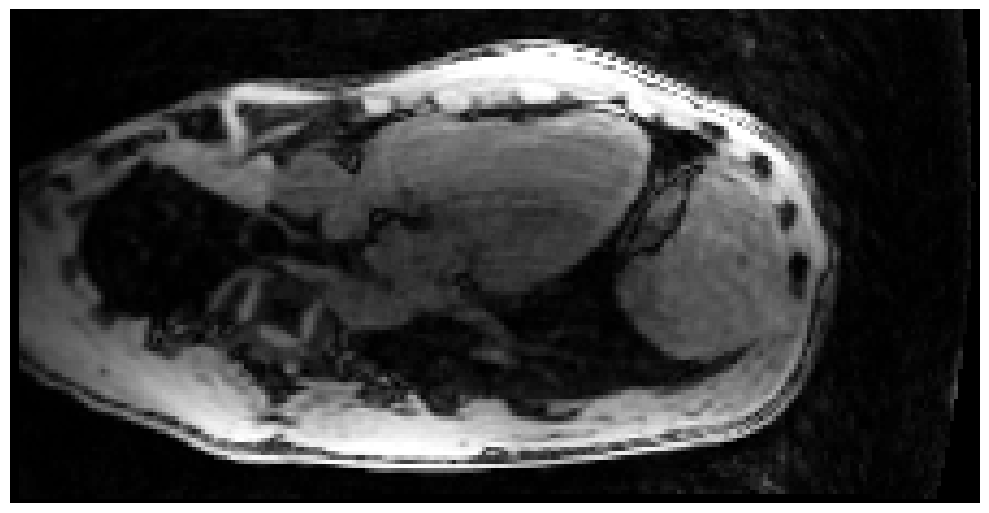

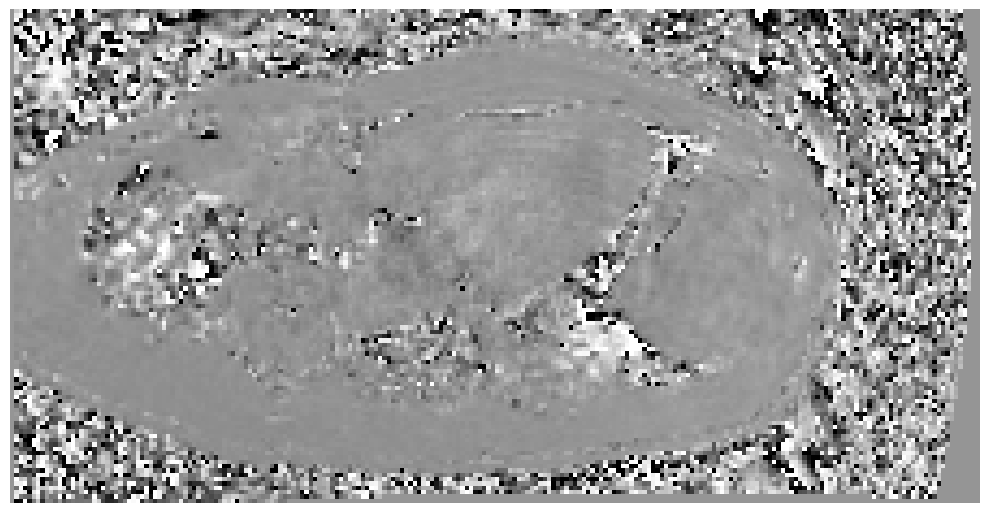

In [ ]:
def create_temporal_comparison_gif_single(spatial_idx, data,  min_v, max_v, title, colormap = 'viridis'):

    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, spatial_idx[0], spatial_idx[1], spatial_idx[2]],interpolation='none', vmin=min_v, vmax=max_v, cmap = colormap)
    # plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, spatial_idx[0], spatial_idx[1], spatial_idx[2]])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = data.shape[0],
                                interval = 100, repeat = False) # in ms)
    anim.save(f'{eval_dir}/Animate_invivo_{title}_18_faster2.gif', fps=30)

idx_slice = np.index_exp[ 30, 40:, :]
create_temporal_comparison_gif_single(idx_slice, v_data['maybemag2'], 0, np.quantile(v_data['maybemag2'][10], 0.99), title=f'Vincent_mag', colormap='Greys_r' )
create_temporal_comparison_gif_single(idx_slice, v_data['maybemag'], np.quantile(v_data['maybemag'][10,  idx_slice[0], idx_slice[1], idx_slice[2]], 0.01), np.quantile(v_data['maybemag'][10,  idx_slice[0], idx_slice[1], idx_slice[2]], 0.99), title=f'Vincent_v', colormap='Greys_r' )

In [ ]:
file_1 = '../data/CARDIAC/M1_2mm_step2_invivoP01_magnitude_adapted_noise.h5'
file_2 = '../data/CARDIAC/M1_2mm_step2_invivoP01_magnitude_adapted_noisy.h5'

mag_colnames = ['mag_u', 'mag_v', 'mag_w']

data_1 = {}
data_2 = {}
with h5py.File(file_1, mode = 'r' ) as p1:
    with h5py.File(file_2, mode = 'r') as p2:
        for mag in mag_colnames:
            data_1[mag] = np.asarray(p1[mag])
            data_2[mag] = np.asarray(p2[mag])
            print('diff:', np.linalg.norm(data_1[mag] - data_2[mag]))

print(data_1['mag_u'].shape, data_2['mag_u'].shape)


@widgets.interact(frame=(0, data_1['mag_u'].shape[0]-1), x = (0, data_1['mag_u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    idx_slice = np.index_exp[frame, x, :, :]
    plt.imshow(data_1['mag_u'][idx_slice], cmap= 'Greys_r')
    plt.title('New uncompressed mag')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(data_2['mag_u'][idx_slice], cmap= 'Greys_r')
    plt.title('Old compressed mag')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(data_1['mag_u'][idx_slice] - data_2['mag_u'][idx_slice], cmap= 'Greys_r')
    plt.title('Difference')
    plt.axis('off')



FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data/CARDIAC/M1_2mm_step2_invivoP01_magnitude_adapted_noise.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
in_vivo_path = '../data/PIA/THORAX/P01/h5/P01.h5'
data_original = {}
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = [ 'mag_u', 'mag_v', 'mag_w']
vencs = {}

with h5py.File(in_vivo_path, mode = 'r' ) as p1:
            mask =  np.asarray(p1['mask'])
            temporal_mask = mask.copy()
            data_original['mask'] = temporal_mask
            for vel, venc, mag in zip(vel_colnames, venc_colnames, mag_colnames):
                data_original[vel] = np.asarray(p1[vel])
                data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)
                data_original[mag] = np.asarray(p1[mag])


N_frames = data_original['u'].shape[0]
print("Max val:", np.max(data_original['u']), np.max(data_original['v']), np.max(data_original['w']))
print("Min val:", np.min(data_original['u']), np.min(data_original['v']), np.min(data_original['w']))

bounds, core_mask = get_boundaries(temporal_mask)
magn = np.sqrt(data_original['mag_u']**2 + data_original['mag_v']**2 + data_original['mag_w']**2)

Max val: 1.5 1.4992676 1.4992676
Min val: -1.4992676 -1.5 -1.5


In [ ]:
@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.figure(figsize=(10, 10))
    N  =3
    plt.subplot(1, N, 1)
    plt.imshow(data_original['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Data, u')
    plt.axis('off')

    # plt.subplot(1, N, 2)
    # plt.imshow(data_original['u_fluid'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    # plt.title('new mask')
    # plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(data_original['mag_u'][frame, x, :, :])
    plt.title('mag')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(data_original['mask'][frame, x, :, :])#-data_original['mask'][frame, x, :, :])
    plt.title('mask')
    plt.axis('off')

interactive(children=(IntSlider(value=5, description='frame', max=24), IntSlider(value=0, description='x', max…

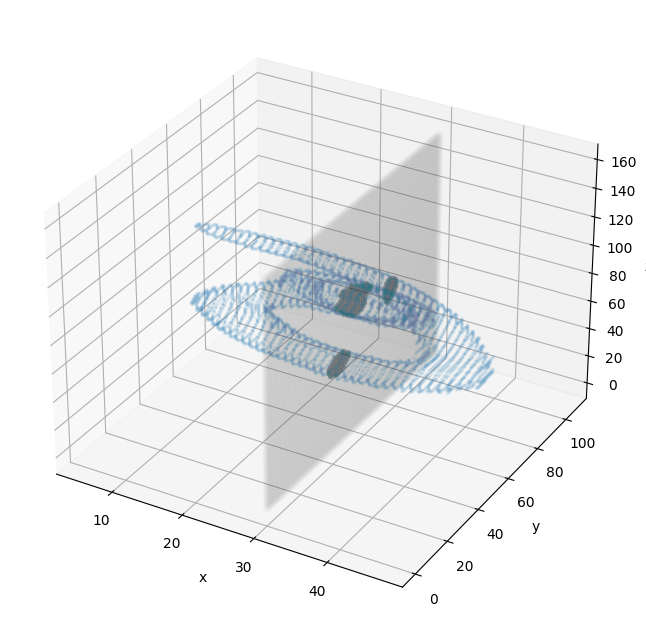

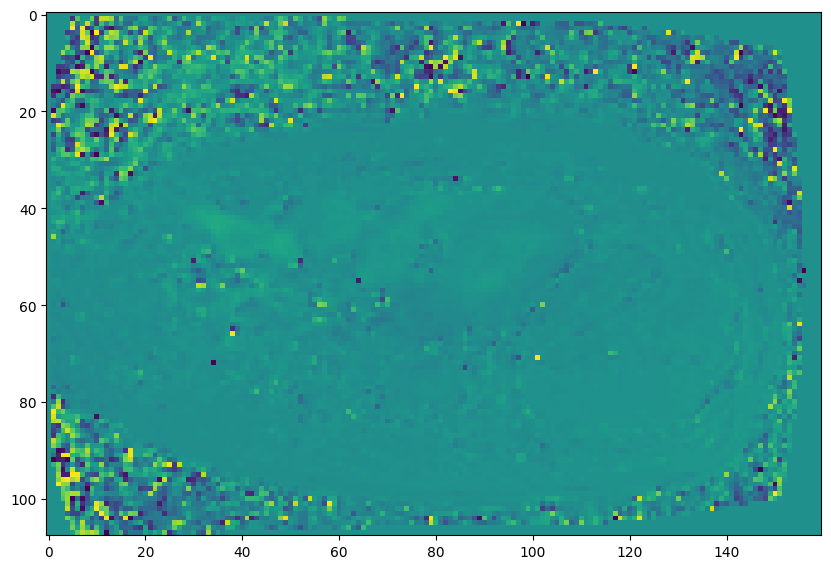

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

idx_plane = np.index_exp[30, :, :]
cube_plane = np.zeros_like(data_original['u'][0])

cube_plane[idx_plane] = 1 # change this for every slice
x_plane, y_plane, z_plane = np.where(cube_plane == 1)
x_bounds, y_bounds, z_bounds = np.where(bounds[0, :, :, :] ==1)
intersec_plane = data_original['mask'][0, :, :, :].copy()
# intersec_plane += np.array(cube_plane, dtype = np.uint16)
# intersec_plane[np.where(cube_plane == 1)] = 0
intersec_plane[idx_plane] +=1
x_intersec, y_intersec, z_intersec = np.where(intersec_plane == 2)

fig = plt.figure()
# ax.view_init(15, angle)
#plt.zlabel('z')
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter3D(x_plane, y_plane, z_plane, color = 'grey',alpha = 0.01 )
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1)
ax.scatter3D(x_intersec, y_intersec, z_intersec, s= 3, alpha = 0.1, color = 'black')


plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.savefig('../results/data/THORAX')
plt.show()
plt.imshow(data_original['u'][10][idx_plane])
